## CSCI S-89 Introduction to Deep Learning
Harvard Summer School 2025

# Final Project:
# *Face Recognition with Deep Learning*

The goal of this project is to detect human faces in images and recognize who the faces belong to from a predefined group of people.

# Part IV: **Build, Train, and Evaluate Face Recognition Model**

## B. **Use Transfer Learning**

I was not fully satisfied with the results from my previous model. With only 80 images per person, even though I used data augmentation, dropout layers, and L2 Regularization, I was concerned about overfitting and how well the model generalizes. Most importantly, the model's predictions were inconsistent, occasionally assigning incorrect labels to people, even though the mismatched person looked somewhat similar to the person behind the label. Looking for a more robust and reliable solution, I came across this article by Wei-Meng Lee <sup>[3]</sup> about how we can use **transfer learning** for face recognition, and I thought I should try it out and see if this would work better.

We will use **MobileNetV2**. MobileNetV2 is a pretrained Convolutional Neural Network that is designed for image classification tasks, is relatively lightweight, and combines speed, accuracy, and computational efficiency. We will use the pretrained model for feature extraction, add our own classifier, and train the model on our dataset. We will **fine-tune** the last 10% of the pretrained model layers, to improve validation accuracy.

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2.
pretrained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False, # we will add our own classifier
    weights='imagenet' # load pretrained weights
)

# We will try fine-tuning,
# to see if we can improve the accuracy
# further from 70-72%.

pretrained_model.trainable = False # Don't let the pretrained weights be updated during training (initially).

# Get the number of layers in the pretrained model.
layers = len(pretrained_model.layers)

# Define the percentage of the layers we want to unfreeze.
unfreeze_percentage = 0.1 # 10%

# Take the number of layers we will unfreeze.
unfreeze_layers = int(unfreeze_percentage * layers)

# Unfreeze the layers.
for layer in pretrained_model.layers[-unfreeze_layers:]:
  layer.trainable = True

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

# Build model.
model = models.Sequential()
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(20,activation='softmax')) # multiclass classification problem with 20 classes

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,060 (9.88 MB)

 Trainable params: 1,373,076 (5.24 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile model.
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1e-5), # This is important! I tried 0.001 and 1e-4 and it didn't work well.
              metrics=['accuracy'])

In [ ]:
# Train model.
history = model.fit(
      train_ds_scaled_aug,
      epochs=200,
      validation_data=val_ds_scaled)

In [ ]:
# Save model after training.
model.save('/content/drive/MyDrive/CSCI S-89 Deep Learning/FinalProject/MobileNetV2_model.keras')

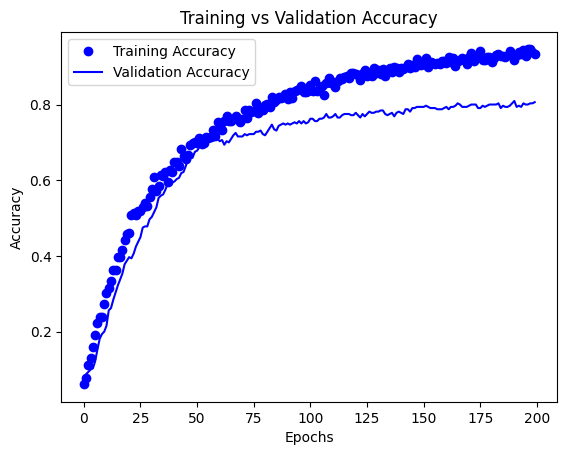

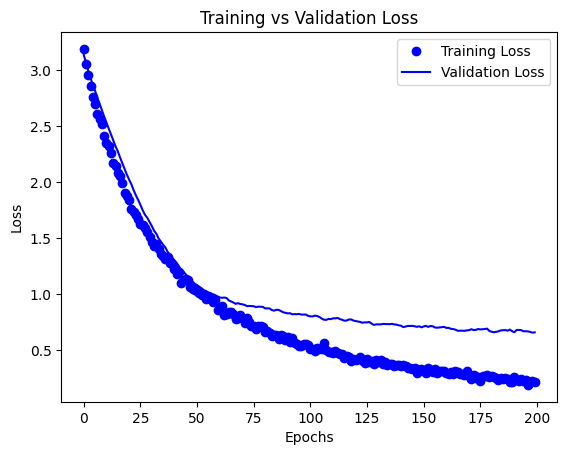

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss per epoch.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title(f'Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title(f'Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_ds_scaled)
print(f'Validation Accuracy: {val_acc:.2f}')
print(f'Validation Loss: {val_loss:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7697 - loss: 0.8104
Validation Accuracy: 0.81
Validation Loss: 0.66


I'm very pleased with the performance of this model. Both the training and the validation curves are smooth, steadily improving, and remain adequately close to each other. We reach a **validation accuracy** of **81%**, which is great. The model appears to **generalize well** and there are **no signs of overfitting**.<br><br>
To sum up, these are the tools, practices, and techniques we used for these results:<br>
*   **MobileNetV2** as a pretrained backbone for feature extraction,
*   **Fine-tuning** for **the last 10% of the layers** of the pretrained model (without this the validation accuracy would plateau at around 70-72%),
*   Custom classifier with **256 neurons** and a **Dropout layer** of rate 0.3,
*   **Adam** optimizer with **learning rate 1e-5** (0.001 or 1e-4 would not work well),
*   **200 epochs** (to allow the model to converge).

Let's now display a confusion matrix heatmap for the validation dataset and see how the model performs across all classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step



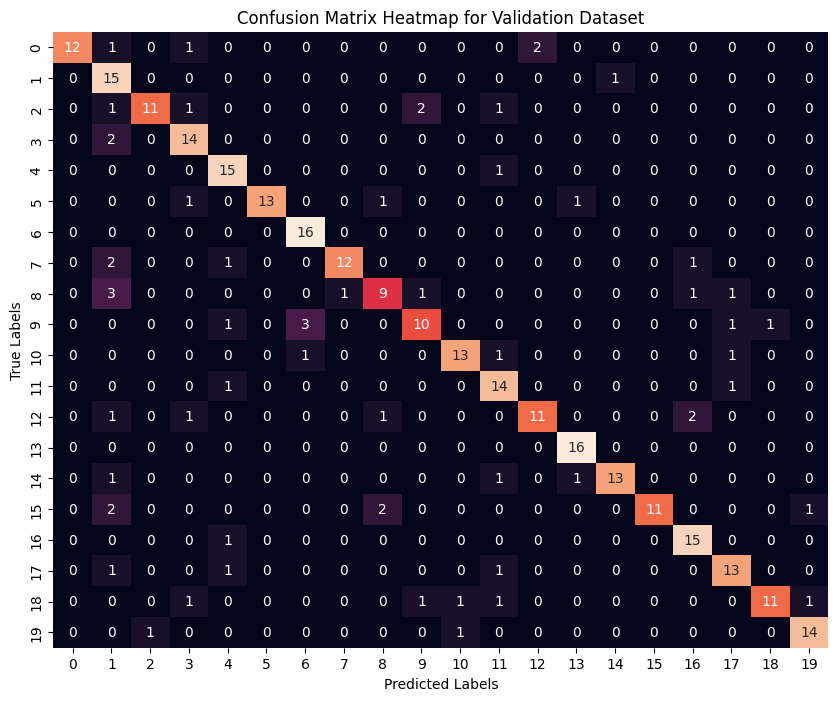

0: Alexandra Daddario
1: Anastasia
2: Andy Samberg
3: Billie Eilish
4: Brad Pitt
5: Camila Cabello
6: Christos
7: Claire Holt
8: Courtney Cox
9: Henry Cavill
10: Hrithik Roshan
11: Hugh Jackman
12: Jessica Alba
13: Kyriaki
14: Mitsos
15: Natalie Portman
16: Priyanka Chopra
17: Robert Downey Jr
18: Vijay Deverakonda
19: Zac Efron


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix

# Get class names.
class_names = train_ds.class_names

# Get true labels and predicted labels for the validation dataset.
y_true = []
y_pred = []

# For all the images in the validation dataset...
for image, label in val_ds_scaled:
  pred = model.predict(image) # predict the label for the image
  y_true.extend(np.argmax(label.numpy(), axis=1))
  y_pred.extend(np.argmax(pred, axis=1))

# Compute the confusion matrix.
cm = confusion_matrix(y_true, y_pred)

print()
# Plot the confusion matrix.
plt.figure(figsize=(10, 8))
seaborn.heatmap(cm, annot=True, fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap for Validation Dataset')
plt.show()

# Show each index to which person it maps.
for index, name in enumerate(class_names):
  print(f'{index}: {name}')

For the most part, most predictions are aligned along the diagonal. There are some mismatches, but only a few, and between people that have similar facial features and structure, like Brad Pitt and Robert Downey Jr.

Let's now test our trained model on a separate dataset (test dataset). This dataset contains new images for our 20 people, different from the ones we used for training and validation. For the celebrities in the Kaggle dataset, I collected one additional photo per person from Google Images, ensuring they were different from the original Kaggle images, and for myself, my friends, and family, again I collected one additional photo per person.

In [ ]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load MTCNN face detector.
face_detector = MTCNN()

# Define the input image size for the model.
model_image_size = (224, 224)

# Get the folder with the test images.
test_dir = os.path.join(target_folder, 'test')

# Get people's names.
labels = train_ds.class_names

# For all test images.
for test_img in os.listdir(test_dir):
  # Take the image.
  image_path = os.path.join(test_dir, test_img)

  # Prepare image for MTCNN and OpenCV processing.
  img = cv2.imread(image_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Detect faces.
  faces = face_detector.detect_faces(img_rgb)

  # For every face in the image...
  for face in faces:
    # Get coordinates of the face.
    x, y, w, h = face['box']
    x, y = max(0, x), max(0, y) # make sure coords are non negative

    face_img = img_rgb[y:y+h, x:x+w] # Crop the face out of the image.

    # Prepare the face for the model.
    face_resized = cv2.resize(face_img, model_image_size)
    face_array = np.expand_dims(face_resized / 255.0, axis=0)

    # Make prediction.
    pred = model.predict(face_array) # this returns probabilities of matching for all the classes in the dataset
    max_prob = np.max(pred)
    max_prob_index = np.argmax(pred)

    label = f'{labels[max_prob_index]} ({max_prob:.2f})'
    print(label)

    # Draw box and annotation for the face.
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

  # Display results.
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

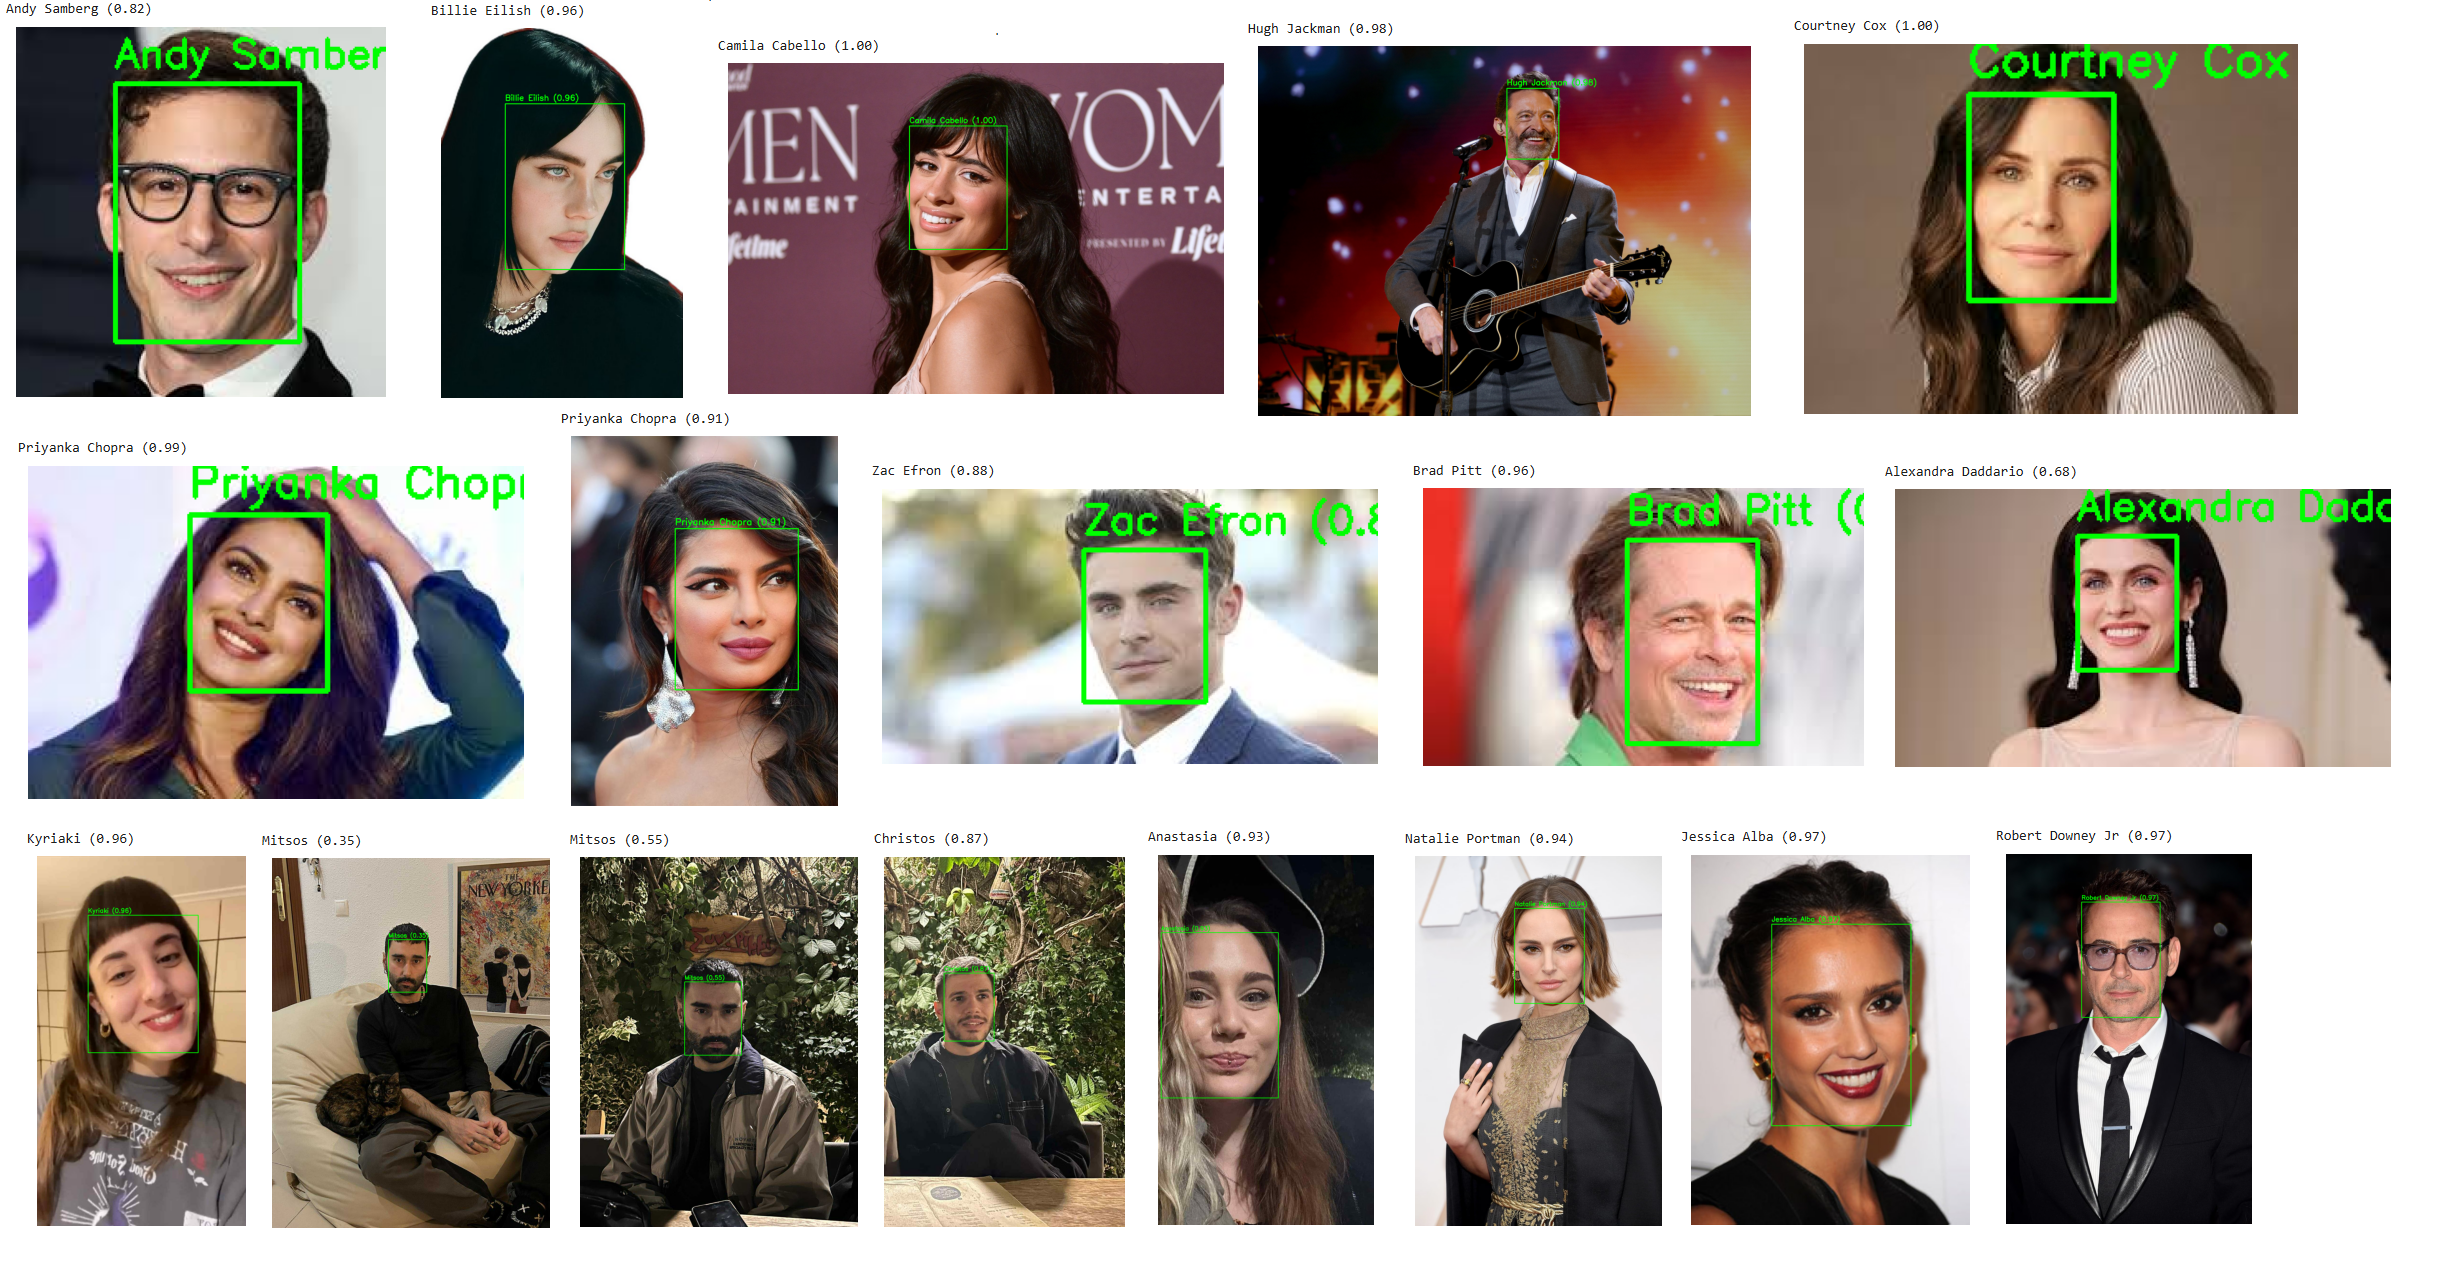

The model successfully recognizes all faces in the test dataset.